In [99]:
# from analysis_utils import *
import importlib
import analysis_utils
importlib.reload(analysis_utils)
from analysis_utils import *

In [100]:
# Paths to csv's holding response values and sentence lengths
# dim0 represents the LM separator, dim1 represents the author
wiki_paths = [
                [ 
                  "Responses/wiki_Llama3.1_clean_none_Meta-Llama-3.1-8B-Instruct.csv",
                  "Responses/wiki_Falcon_clean_none_Meta-Llama-3.1-8B-Instruct.csv",
                  "Responses/wiki_human_text_none_Meta-Llama-3.1-8B-Instruct.csv",
                  "Responses/wiki_gpt_clean_none_Meta-Llama-3.1-8B-Instruct.csv",
                  "Responses/wiki_R1_clean_none_Meta-Llama-3.1-8B-Instruct.csv"
                ],
                [ 
                  "Responses/wiki_Llama3.1_clean_none_falcon-7b.csv",
                  "Responses/wiki_Falcon_clean_none_falcon-7b.csv",
                  "Responses/wiki_human_text_none_falcon-7b.csv",
                  "Responses/wiki_gpt_clean_none_falcon-7b.csv",
                  "Responses/wiki_R1_clean_none_falcon-7b.csv"
                ],
                [ 
                  "Responses/wiki_Llama3.1_clean_none_phi-2.csv",
                  "Responses/wiki_Falcon_clean_none_phi-2.csv",
                  "Responses/wiki_human_text_none_phi-2.csv",
                  "Responses/wiki_gpt_clean_none_phi-2.csv",
                  "Responses/wiki_R1_clean_none_phi-2.csv"
                ],
                [ 
                  "Responses/wiki_Llama3.1_clean_none_DeepSeek-R1-Distill-Qwen-7B.csv",
                  "Responses/wiki_Falcon_clean_none_DeepSeek-R1-Distill-Qwen-7B.csv",
                  "Responses/wiki_human_text_none_DeepSeek-R1-Distill-Qwen-7B.csv",
                  "Responses/wiki_gpt_clean_none_DeepSeek-R1-Distill-Qwen-7B.csv",
                  "Responses/wiki_R1_clean_none_DeepSeek-R1-Distill-Qwen-7B.csv"
                ]
]

news_paths = [
                [
                "Responses/news_Llama3.1_clean_none_Meta-Llama-3.1-8B-Instruct.csv",
                "Responses/news_Falcon_clean_none_Meta-Llama-3.1-8B-Instruct.csv",
                "Responses/news_human_text_none_Meta-Llama-3.1-8B-Instruct.csv",
                "Responses/news_gpt_clean_none_Meta-Llama-3.1-8B-Instruct.csv",
                "Responses/news_R1_clean_none_Meta-Llama-3.1-8B-Instruct.csv"
                ],
                [
                "Responses/news_Llama3.1_clean_none_falcon-7b.csv",
                "Responses/news_Falcon_clean_none_falcon-7b.csv",
                "Responses/news_human_text_none_falcon-7b.csv",
                "Responses/news_gpt_clean_none_falcon-7b.csv",
                "Responses/news_R1_clean_none_falcon-7b.csv"
                ],
                [
                "Responses/news_Llama3.1_clean_none_phi-2.csv",
                "Responses/news_Falcon_clean_none_phi-2.csv",
                "Responses/news_human_text_none_phi-2.csv",
                "Responses/news_gpt_clean_none_phi-2.csv",
                "Responses/news_R1_clean_none_phi-2.csv"
                ],
                [
                "Responses/news_Llama3.1_clean_none_DeepSeek-R1-Distill-Qwen-7B.csv",
                "Responses/news_Falcon_clean_none_DeepSeek-R1-Distill-Qwen-7B.csv",
                "Responses/news_human_text_none_DeepSeek-R1-Distill-Qwen-7B.csv",
                "Responses/news_gpt_clean_none_DeepSeek-R1-Distill-Qwen-7B.csv",
                "Responses/news_R1_clean_none_DeepSeek-R1-Distill-Qwen-7B.csv"
                ]
]

abstracts_paths = [
                [
                "Responses/abstracts_Llama3.1_clean_none_Meta-Llama-3.1-8B-Instruct.csv",
                "Responses/abstracts_Falcon_clean_none_Meta-Llama-3.1-8B-Instruct.csv",
                "Responses/abstracts_human_text_none_Meta-Llama-3.1-8B-Instruct.csv",
                "Responses/abstracts_gpt_clean_none_Meta-Llama-3.1-8B-Instruct.csv",
                "Responses/abstracts_R1_clean_none_Meta-Llama-3.1-8B-Instruct.csv"
                ],
                [
                "Responses/abstracts_Llama3.1_clean_none_falcon-7b.csv",
                "Responses/abstracts_Falcon_clean_none_falcon-7b.csv",
                "Responses/abstracts_human_text_none_falcon-7b.csv",
                "Responses/abstracts_gpt_clean_none_falcon-7b.csv",
                "Responses/abstracts_R1_clean_none_falcon-7b.csv"
                ],
                [
                "Responses/abstracts_Llama3.1_clean_none_phi-2.csv",
                "Responses/abstracts_Falcon_clean_none_phi-2.csv",
                "Responses/abstracts_human_text_none_phi-2.csv",
                "Responses/abstracts_gpt_clean_none_phi-2.csv",
                "Responses/abstracts_R1_clean_none_phi-2.csv"
                ],
                [
                "Responses/abstracts_Llama3.1_clean_none_DeepSeek-R1-Distill-Qwen-7B.csv",
                "Responses/abstracts_Falcon_clean_none_DeepSeek-R1-Distill-Qwen-7B.csv",
                "Responses/abstracts_human_text_none_DeepSeek-R1-Distill-Qwen-7B.csv",
                "Responses/abstracts_gpt_clean_none_DeepSeek-R1-Distill-Qwen-7B.csv",
                "Responses/abstracts_R1_clean_none_DeepSeek-R1-Distill-Qwen-7B.csv"
                ]
]

In [54]:
# use auc/js/optimal_error
print(f"Wikipedia dataset")
compare_author_vs_others(wiki_paths, metric='auc')
print(f"News dataset")
compare_author_vs_others(news_paths, metric='auc')
print(f"Abstracts dataset")
compare_author_vs_others(abstracts_paths, metric='auc')

Wikipedia dataset

=== Average Author Separation using AUC ===
+--------------------+-------------------------+-------------+---------+-------------------------------+
|  Author vs Others  |  Llama-3.1-8B-Instruct  |  Falcon-7b  |  Phi-2  |  DeepSeek-R1-Distill-Qwen-7B  |
+====================+=========================+=============+=========+===============================+
| Llama3.1 vs Others |         0.7549          |   0.6395    | 0.7244  |            0.6619             |
+--------------------+-------------------------+-------------+---------+-------------------------------+
|  Falcon vs Others  |         0.6181          |   0.6713    | 0.6137  |            0.6235             |
+--------------------+-------------------------+-------------+---------+-------------------------------+
|  Human vs Others   |         0.7306          |    0.725    | 0.7758  |            0.7345             |
+--------------------+-------------------------+-------------+---------+-------------------------

In [53]:
# use auc/js/optimal_error
print(f"Wikipedia dataset")
compare_author_vs_others(wiki_paths, metric='optimal_error')
print(f"News dataset")
compare_author_vs_others(news_paths, metric='optimal_error')
print(f"Abstracts dataset")
compare_author_vs_others(abstracts_paths, metric='optimal_error')

Wikipedia dataset

=== Average Author Separation using OPTIMAL_ERROR ===
+--------------------+-------------------------+-------------+---------+-------------------------------+
|  Author vs Others  |  Llama-3.1-8B-Instruct  |  Falcon-7b  |  Phi-2  |  DeepSeek-R1-Distill-Qwen-7B  |
+====================+=========================+=============+=========+===============================+
| Llama3.1 vs Others |         0.5082          |   0.2019    | 0.4648  |            0.2361             |
+--------------------+-------------------------+-------------+---------+-------------------------------+
|  Falcon vs Others  |         0.2543          |   0.3807    | 0.3063  |             0.211             |
+--------------------+-------------------------+-------------+---------+-------------------------------+
|  Human vs Others   |          0.556          |   0.4537    | 0.7169  |            0.5153             |
+--------------------+-------------------------+-------------+---------+---------------

In [55]:
print(f"Wikipedia dataset")
compare_author_vs_others(wiki_paths, metric='js')
print(f"News dataset")
compare_author_vs_others(news_paths, metric='js')
print(f"Abstracts dataset")
compare_author_vs_others(abstracts_paths, metric='js')

Wikipedia dataset

=== Average Author Separation using JS ===
+--------------------+-------------------------+-------------+---------+-------------------------------+
|  Author vs Others  |  Llama-3.1-8B-Instruct  |  Falcon-7b  |  Phi-2  |  DeepSeek-R1-Distill-Qwen-7B  |
+====================+=========================+=============+=========+===============================+
| Llama3.1 vs Others |         0.1219          |   0.0543    | 0.1126  |            0.0616             |
+--------------------+-------------------------+-------------+---------+-------------------------------+
|  Falcon vs Others  |         0.0495          |   0.0744    |  0.058  |            0.0407             |
+--------------------+-------------------------+-------------+---------+-------------------------------+
|  Human vs Others   |         0.1072          |   0.0922    | 0.1426  |            0.1051             |
+--------------------+-------------------------+-------------+---------+--------------------------

In [38]:
run_lm_comparison(wiki_paths)
run_lm_comparison(news_paths)
run_lm_comparison(abstracts_paths)


=== Wiki Dataset ===

Per-LM Comparison
+-----------------------------+---------------------------+-------------------------------+----------------------------+--------------------------------+--------------------------+------------------------------+
| LM Separator                |   Avg AUC (LM in authors) |   Avg AUC (LM not in authors) |   Avg Diff (LM in authors) |   Avg Diff (LM not in authors) |   Avg JS (LM in authors) |   Avg JS (LM not in authors) |
|-----------------------------+---------------------------+-------------------------------+----------------------------+--------------------------------+--------------------------+------------------------------|
| Meta llama 3.1 8b instruct  |                  0.754891 |                      0.631825 |                   0.876081 |                       0.390144 |                0.121907  |                    0.0502988 |
| Falcon 7b                   |                  0.671296 |                      0.639077 |                   0

In [48]:
# Use AUC as metric
print(f"Wikipedia dataset")
compare_human_to_llm(wiki_paths)
print(f"News dataset")
compare_human_to_llm(news_paths)
print(f"Abstracts dataset")
compare_human_to_llm(abstracts_paths)

Wikipedia dataset

=== Full Comparison Table: Human vs Generated Texts ===
+-------------+-------------------------+-------------+---------+-------------------------------+
|             |  Llama-3.1-8B-Instruct  |  Falcon-7b  |  Phi-2  |  DeepSeek-R1-Distill-Qwen-7B  |
+=============+=========================+=============+=========+===============================+
| G1 = Humans |         0.8566          |   0.7656    | 0.8765  |            0.7903             |
| G0 = Llama  |                         |             |         |                               |
+-------------+-------------------------+-------------+---------+-------------------------------+
| G1 = Humans |         0.6977          |    0.778    | 0.7376  |            0.6768             |
| G0 = Falcon |                         |             |         |                               |
+-------------+-------------------------+-------------+---------+-------------------------------+
| G1 = Humans |         0.6301          |  

In [45]:
# Use Optimal error exponent as metric
print(f"Wikipedia dataset")
compare_human_to_llm_oe(wiki_paths)
print(f"News dataset")
compare_human_to_llm_oe(news_paths)
print(f"Abstracts dataset")
compare_human_to_llm_oe(abstracts_paths)

Wikipedia dataset

=== Full Comparison Table (Optimal Error Exponent): Human vs Generated Texts ===
+-------------+-------------------------+-------------+---------+-------------------------------+
|             |  Llama-3.1-8B-Instruct  |  Falcon-7b  |  Phi-2  |  DeepSeek-R1-Distill-Qwen-7B  |
+=============+=========================+=============+=========+===============================+
| G0 = Humans |         1.2732          |   0.7437    | 1.4555  |            0.7297             |
| G1 = Llama  |                         |             |         |                               |
+-------------+-------------------------+-------------+---------+-------------------------------+
| G0 = Humans |         0.2802          |   0.5284    | 0.4169  |            0.2176             |
| G1 = Falcon |                         |             |         |                               |
+-------------+-------------------------+-------------+---------+-------------------------------+
| G0 = Humans |   

In [50]:
# Use JS distance as metric
print(f"Wikipedia dataset")
compare_human_to_llm_js(wiki_paths)
print(f"News dataset")
compare_human_to_llm_js(news_paths)
print(f"Abstracts dataset")
compare_human_to_llm_js(abstracts_paths)

Wikipedia dataset

=== Full Comparison Table (JS Distance): Human vs Generated Texts ===
+-------------+-------------------------+-------------+---------+-------------------------------+
|             |  Llama-3.1-8B-Instruct  |  Falcon-7b  |  Phi-2  |  DeepSeek-R1-Distill-Qwen-7B  |
+=============+=========================+=============+=========+===============================+
| G1 = Humans |         0.2247          |   0.1271    | 0.2572  |            0.1405             |
| G0 = Llama  |                         |             |         |                               |
+-------------+-------------------------+-------------+---------+-------------------------------+
| G1 = Humans |         0.0699          |    0.13     |  0.106  |            0.0567             |
| G0 = Falcon |                         |             |         |                               |
+-------------+-------------------------+-------------+---------+-------------------------------+
| G1 = Humans |         0.028

In [51]:
# Apply bootsrapping on responses for confidence interval
compare_human_to_llm_ci(wiki_paths)
compare_human_to_llm_ci(news_paths)
compare_human_to_llm_ci(abstracts_paths)


R1 comparisons: 100%|██████████| 4/4 [00:01<00:00,  2.03it/s]



=== Wiki Dataset Comparison Table with 95% CI (Human vs Generated Texts) ===
+-------------+-------------------------+----------------+----------------+-------------------------------+
|             |  Llama-3.1-8B-Instruct  |   Falcon-7b    |     Phi-2      |  DeepSeek-R1-Distill-Qwen-7B  |
+=============+=========================+================+================+===============================+
| G1 = Humans |       0.857±0.002       |  0.766±0.002   |  0.876±0.002   |          0.790±0.003          |
| G0 = Llama  |     [0.852, 0.862]      | [0.762, 0.770] | [0.872, 0.880] |        [0.786, 0.796]         |
+-------------+-------------------------+----------------+----------------+-------------------------------+
| G1 = Humans |       0.698±0.003       |  0.778±0.003   |  0.738±0.003   |          0.677±0.003          |
| G0 = Falcon |     [0.692, 0.704]      | [0.773, 0.784] | [0.732, 0.743] |        [0.672, 0.683]         |
+-------------+-------------------------+----------------+

R1 comparisons: 100%|██████████| 4/4 [00:05<00:00,  1.25s/it]



=== News Dataset Comparison Table with 95% CI (Human vs Generated Texts) ===
+-------------+-------------------------+----------------+----------------+-------------------------------+
|             |  Llama-3.1-8B-Instruct  |   Falcon-7b    |     Phi-2      |  DeepSeek-R1-Distill-Qwen-7B  |
+=============+=========================+================+================+===============================+
| G1 = Humans |       0.865±0.001       |  0.805±0.002   |  0.878±0.001   |          0.828±0.001          |
| G0 = Llama  |     [0.862, 0.867]      | [0.802, 0.808] | [0.876, 0.881] |        [0.825, 0.830]         |
+-------------+-------------------------+----------------+----------------+-------------------------------+
| G1 = Humans |       0.619±0.002       |  0.674±0.002   |  0.652±0.003   |          0.593±0.003          |
| G0 = Falcon |     [0.616, 0.624]      | [0.669, 0.678] | [0.647, 0.657] |        [0.587, 0.597]         |
+-------------+-------------------------+----------------+

R1 comparisons: 100%|██████████| 4/4 [00:02<00:00,  1.81it/s]


=== Abstracts Dataset Comparison Table with 95% CI (Human vs Generated Texts) ===
+-------------+-------------------------+----------------+----------------+-------------------------------+
|             |  Llama-3.1-8B-Instruct  |   Falcon-7b    |     Phi-2      |  DeepSeek-R1-Distill-Qwen-7B  |
+=============+=========================+================+================+===============================+
| G1 = Humans |       0.762±0.002       |  0.717±0.003   |  0.808±0.002   |          0.677±0.003          |
| G0 = Llama  |     [0.757, 0.766]      | [0.711, 0.722] | [0.805, 0.812] |        [0.672, 0.683]         |
+-------------+-------------------------+----------------+----------------+-------------------------------+
| G1 = Humans |       0.651±0.003       |  0.725±0.003   |  0.745±0.003   |          0.604±0.003          |
| G0 = Falcon |     [0.645, 0.657]      | [0.720, 0.730] | [0.738, 0.751] |        [0.598, 0.611]         |
+-------------+-------------------------+------------

In [128]:
def filter_out_phi2(paths):
    """
    Removes paths containing 'phi-2' in their filenames.
    """
    filtered_paths = []
    for group in paths:
        if not any('phi-2' in path.lower() for path in group):
            filtered_paths.append(group)
    return filtered_paths

wiki_paths_no_phi2 = filter_out_phi2(wiki_paths)
news_paths_no_phi2 = filter_out_phi2(news_paths)
abstracts_paths_no_phi2 = filter_out_phi2(abstracts_paths)

# run_lm_comparison(wiki_paths_no_phi2)
# run_lm_comparison(news_paths_no_phi2)
# run_lm_comparison(abstracts_paths_no_phi2)

run_lm_comparison(wiki_paths)
run_lm_comparison(news_paths)
run_lm_comparison(abstracts_paths)


=== Wiki Dataset ===

Per-LM Comparison
+-----------------------------+---------------+----------------+----------------+-----------------+--------------+---------------+--------------+---------------+
| LM Separator                |   AUC (LM in) |   AUC (LM out) |   Diff (LM in) |   Diff (LM out) |   JS (LM in) |   JS (LM out) |   OE (LM in) |   OE (LM out) |
|-----------------------------+---------------+----------------+----------------+-----------------+--------------+---------------+--------------+---------------|
| Meta llama 3.1 8b instruct  |      0.754891 |       0.631825 |       0.876081 |        0.390144 |    0.121907  |     0.0502988 |     0.508191 |      0.247101 |
| Falcon 7b                   |      0.671296 |       0.639077 |       0.453061 |        0.506823 |    0.074374  |     0.0488523 |     0.361999 |      0.205375 |
| Phi 2                       |      0        |       0.684034 |       0        |        0.632434 |    0         |     0.0859869 |     0        |    

In [50]:
# # optional code for viewing each auc value computed

# print("=== Wiki Dataset ===")
# group1_aucs, group1_diffs, group2_aucs, group2_diffs = [],[],[],[]
# for i, lm_paths in enumerate(wiki_paths):
#     lm_is_author_aucs, lm_is_author_diffs, lm_not_author_aucs, lm_not_author_diffs = lm_aggregate_metrics(lm_paths)
#     group1_aucs.extend(lm_is_author_aucs)
#     group1_diffs.extend(lm_is_author_diffs)
#     group2_aucs.extend(lm_not_author_aucs)
#     group2_diffs.extend(lm_not_author_diffs)
#     _, _, lm_name, _ = extract_info_from_path(lm_paths[0])

#     print(f"\nResults for {lm_name} separator:")
#     print(f"LM-In-Authors:")
#     print(f"    AUCs: {lm_is_author_aucs}")
#     print(f"    Diffs: {lm_is_author_diffs}")
#     print(f"LM-Not-In-Authors:")
#     print(f"    AUCs: {lm_not_author_aucs}")
#     print(f"    Diffs: {lm_not_author_diffs}")

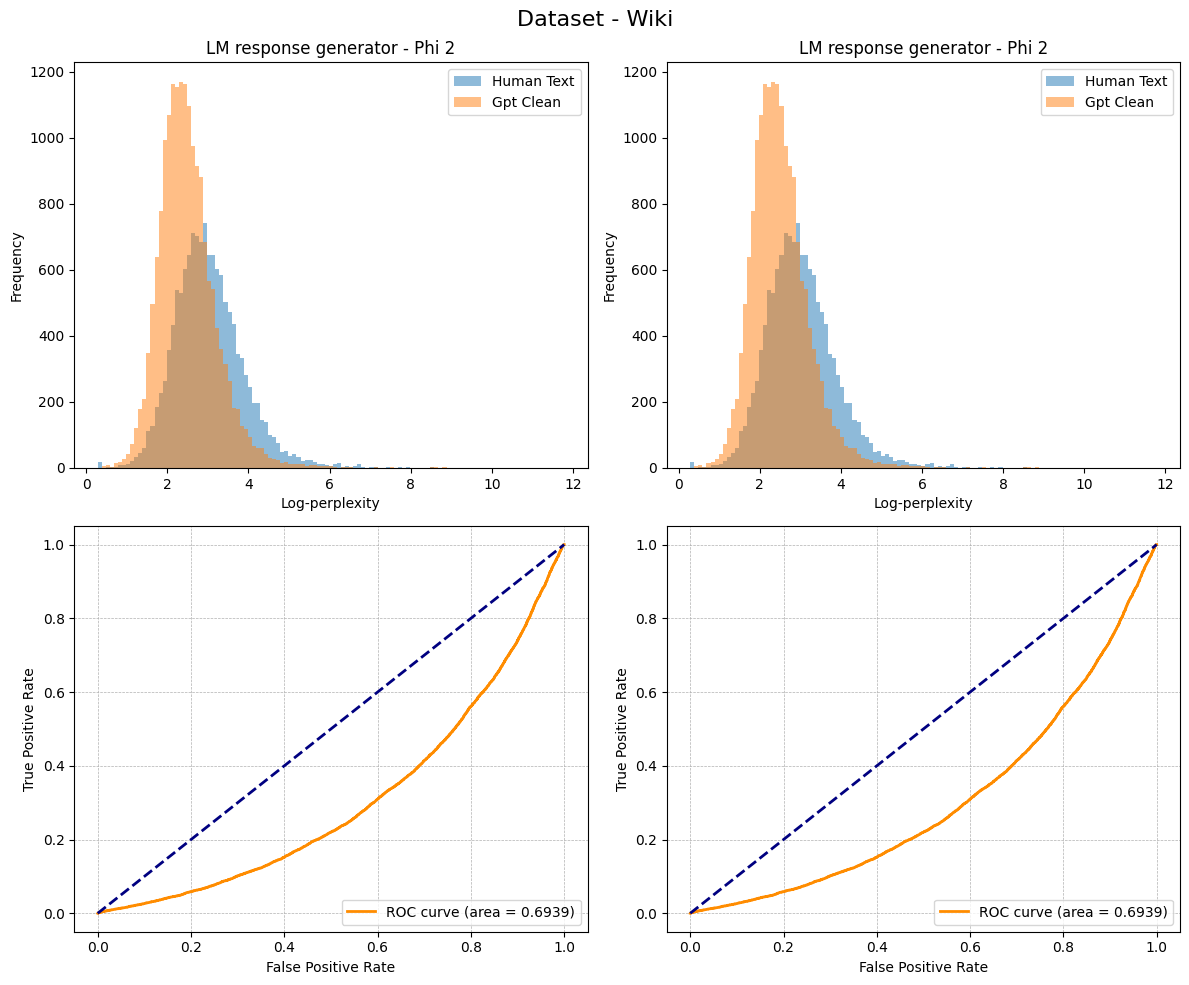

In [72]:
compare_hist('Responses/wiki_human_text_none_phi-2.csv', 
             'Responses/wiki_gpt_clean_none_phi-2.csv', 
             'Responses/wiki_human_text_none_phi-2.csv', 
             'Responses/wiki_gpt_clean_none_phi-2.csv')

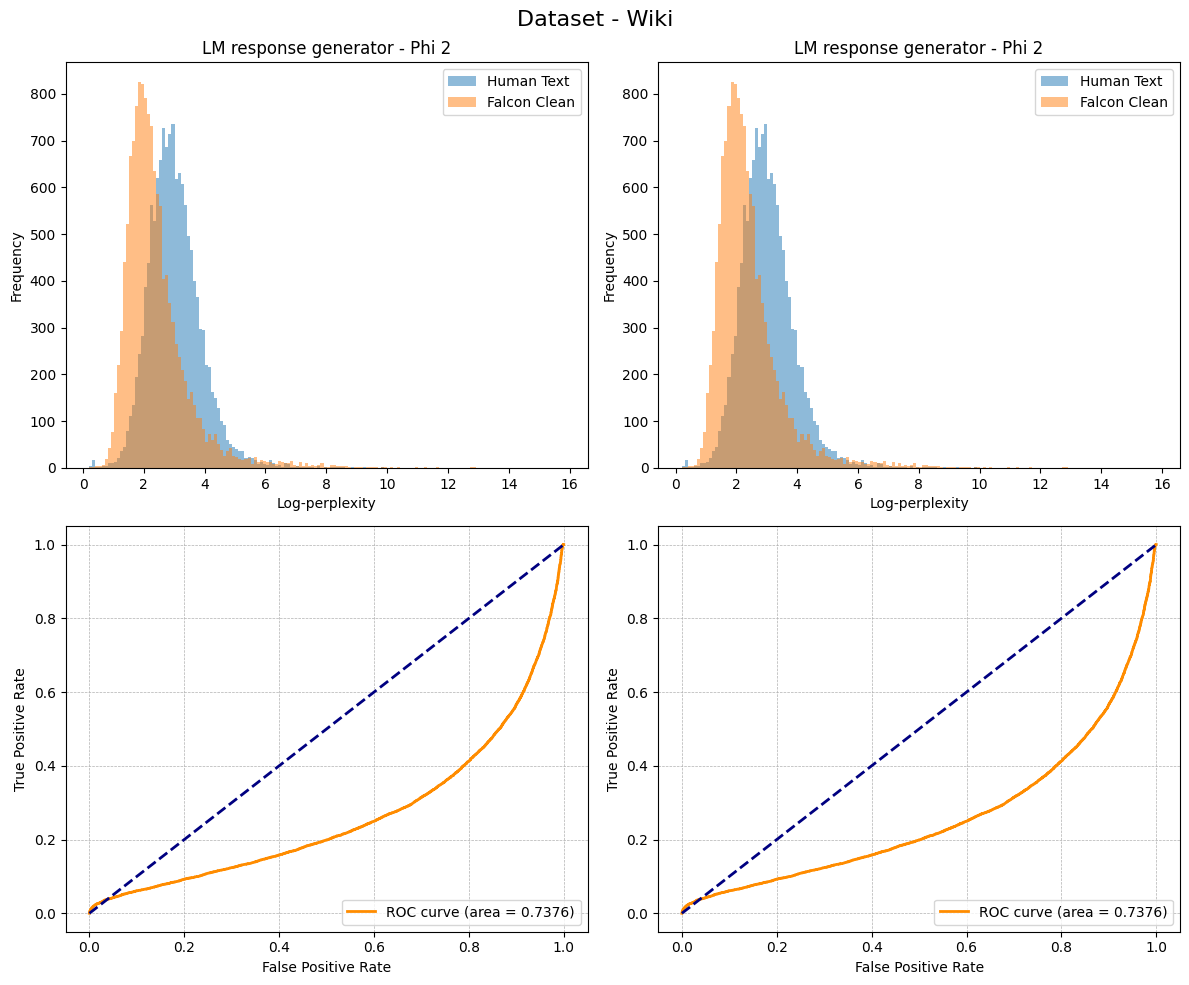

In [71]:
compare_hist('Responses/wiki_human_text_none_phi-2.csv', 
             'Responses/wiki_Falcon_clean_none_phi-2.csv', 
             'Responses/wiki_human_text_none_phi-2.csv', 
             'Responses/wiki_Falcon_clean_none_phi-2.csv')

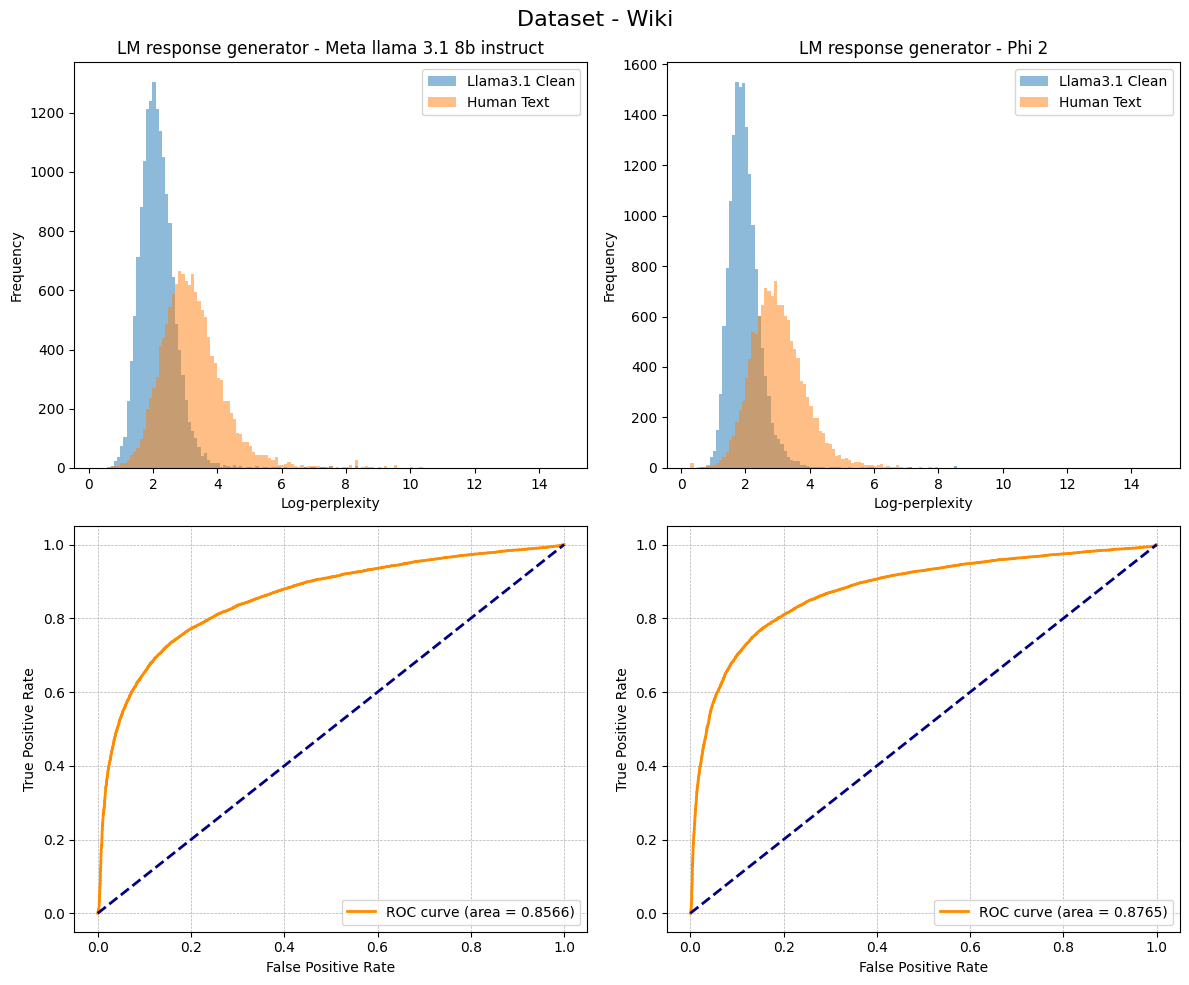

In [51]:
compare_hist('Responses/wiki_Llama3.1_clean_none_Meta-Llama-3.1-8B-Instruct.csv', 
             'Responses/wiki_human_text_none_Meta-Llama-3.1-8B-Instruct.csv', 
             'Responses/wiki_Llama3.1_clean_none_phi-2.csv', 
             'Responses/wiki_human_text_none_phi-2.csv')

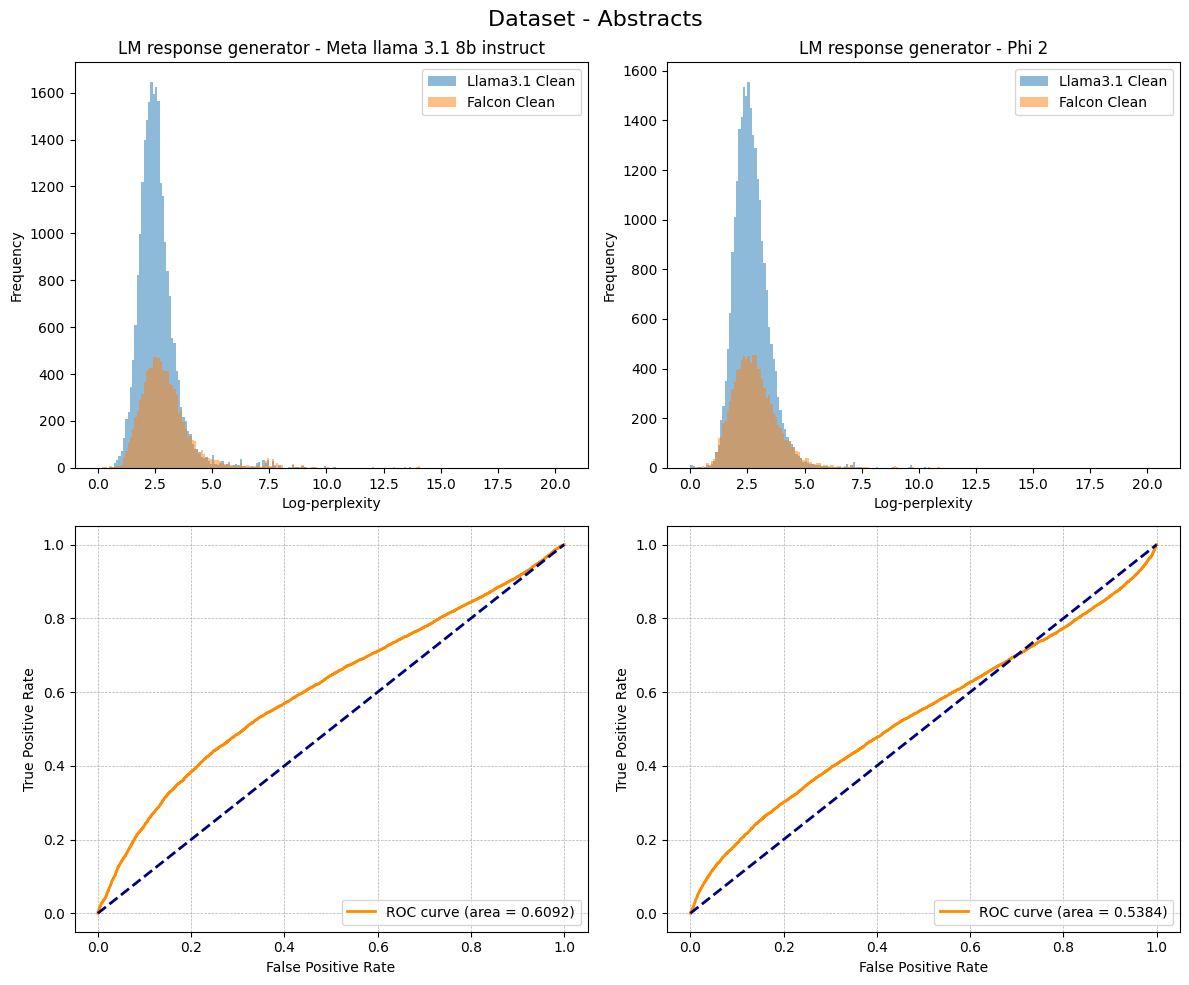

In [65]:
compare_hist('Responses/abstracts_Llama3.1_clean_none_Meta-Llama-3.1-8B-Instruct.csv', 
             'Responses/abstracts_Falcon_clean_none_Meta-Llama-3.1-8B-Instruct.csv', 
             'Responses/abstracts_Llama3.1_clean_none_phi-2.csv', 
             'Responses/abstracts_Falcon_clean_none_phi-2.csv')

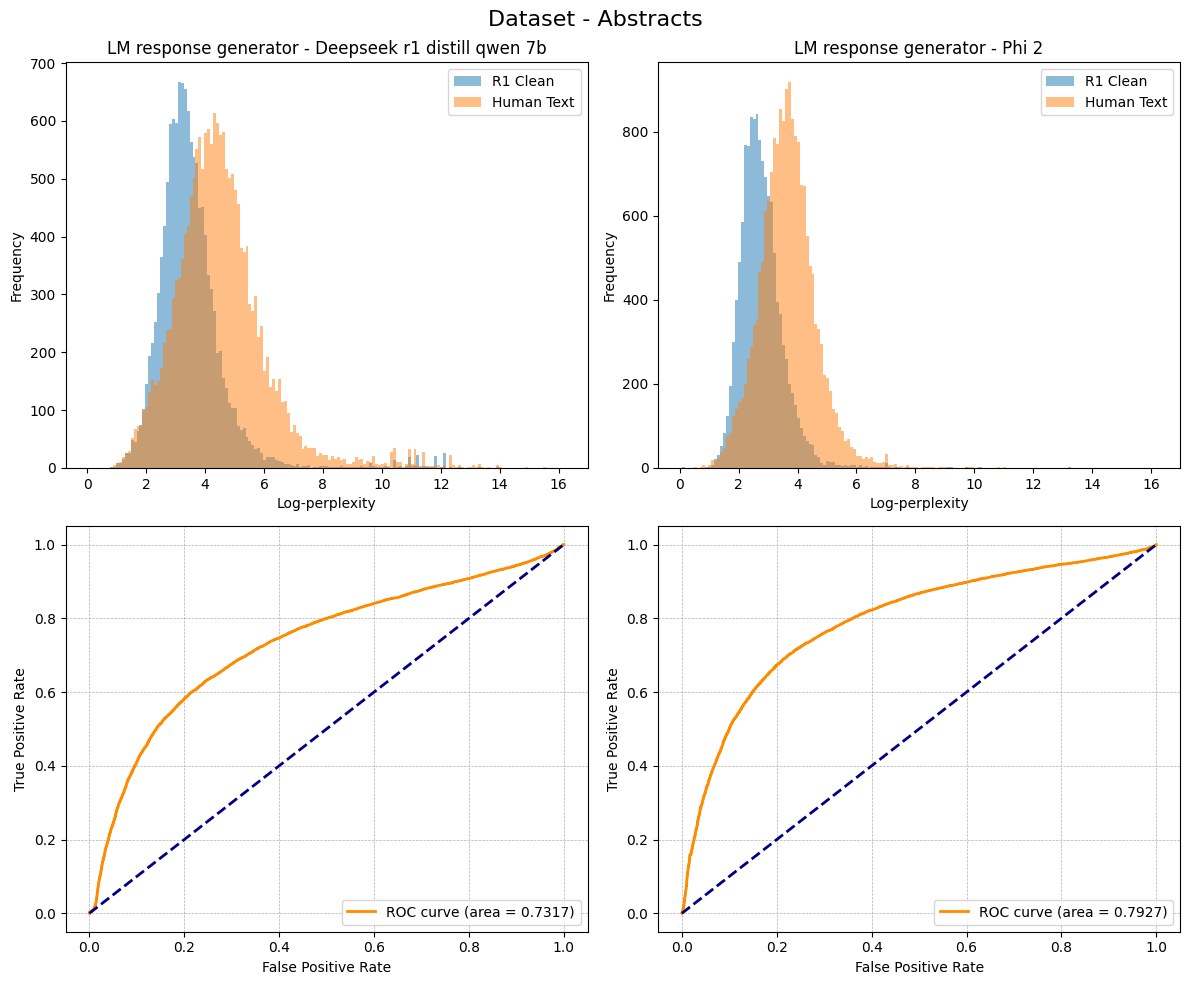

In [79]:
compare_hist('Responses/abstracts_R1_clean_none_DeepSeek-R1-Distill-Qwen-7B.csv', 
             'Responses/abstracts_human_text_none_DeepSeek-R1-Distill-Qwen-7B.csv', 
             'Responses/abstracts_R1_clean_none_phi-2.csv', 
             'Responses/abstracts_human_text_none_phi-2.csv')

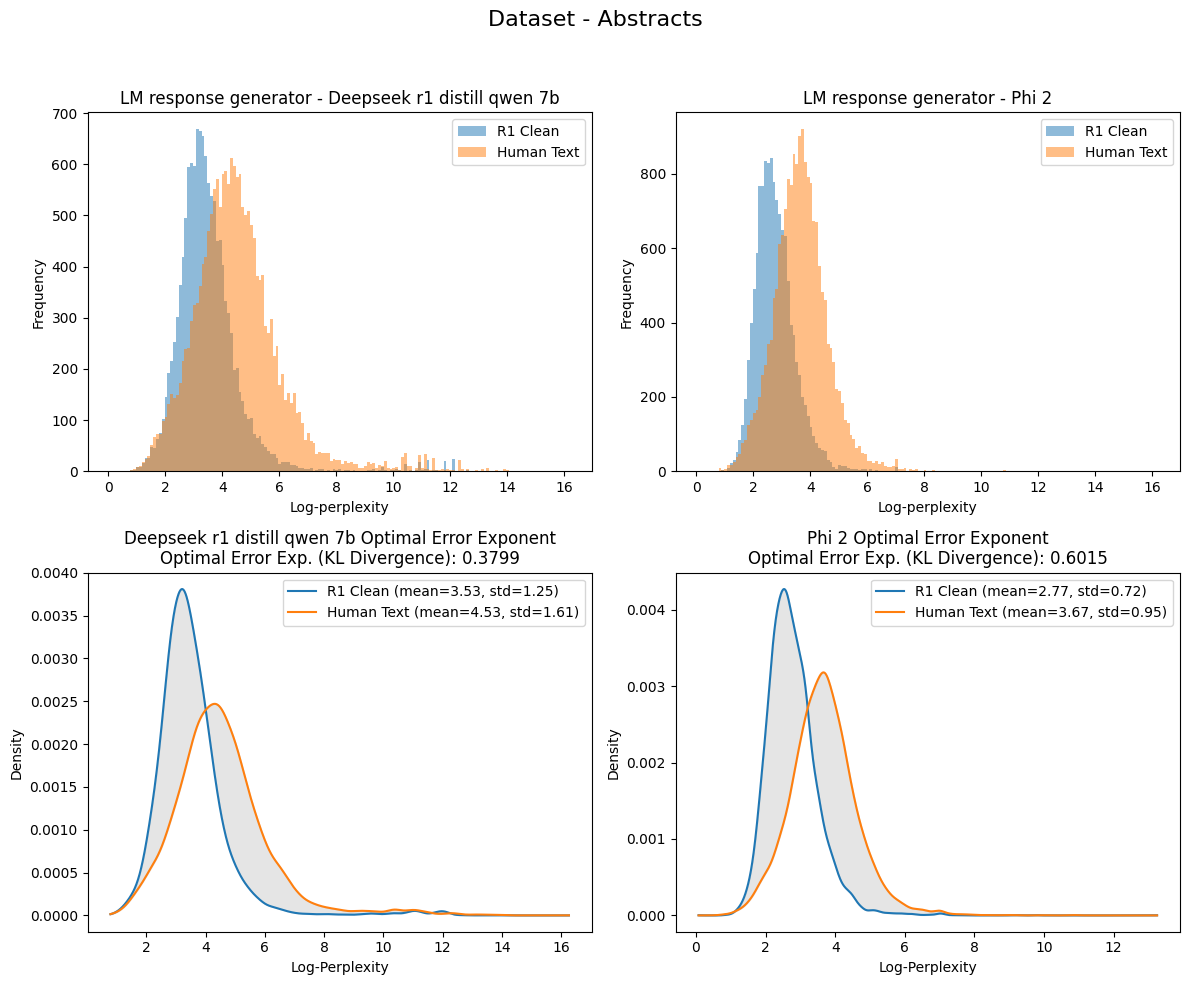

In [101]:
compare_hist_oe('Responses/abstracts_R1_clean_none_DeepSeek-R1-Distill-Qwen-7B.csv', 
             'Responses/abstracts_human_text_none_DeepSeek-R1-Distill-Qwen-7B.csv', 
             'Responses/abstracts_R1_clean_none_phi-2.csv', 
             'Responses/abstracts_human_text_none_phi-2.csv')

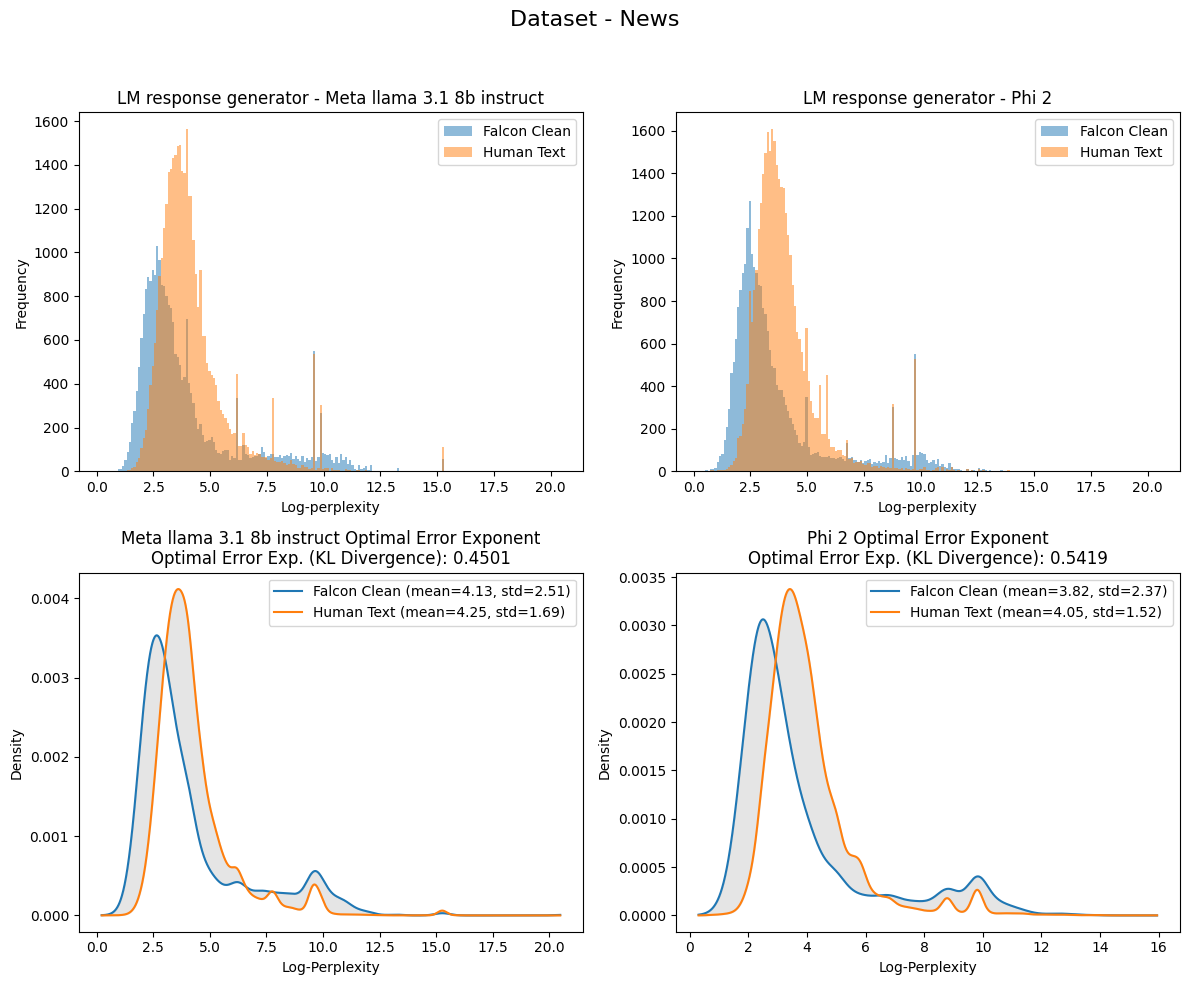

In [102]:
compare_hist_oe('Responses/news_Falcon_clean_none_Meta-Llama-3.1-8B-Instruct.csv', 
             'Responses/news_human_text_none_Meta-Llama-3.1-8B-Instruct.csv', 
             'Responses/news_Falcon_clean_none_phi-2.csv', 
             'Responses/news_human_text_none_phi-2.csv')

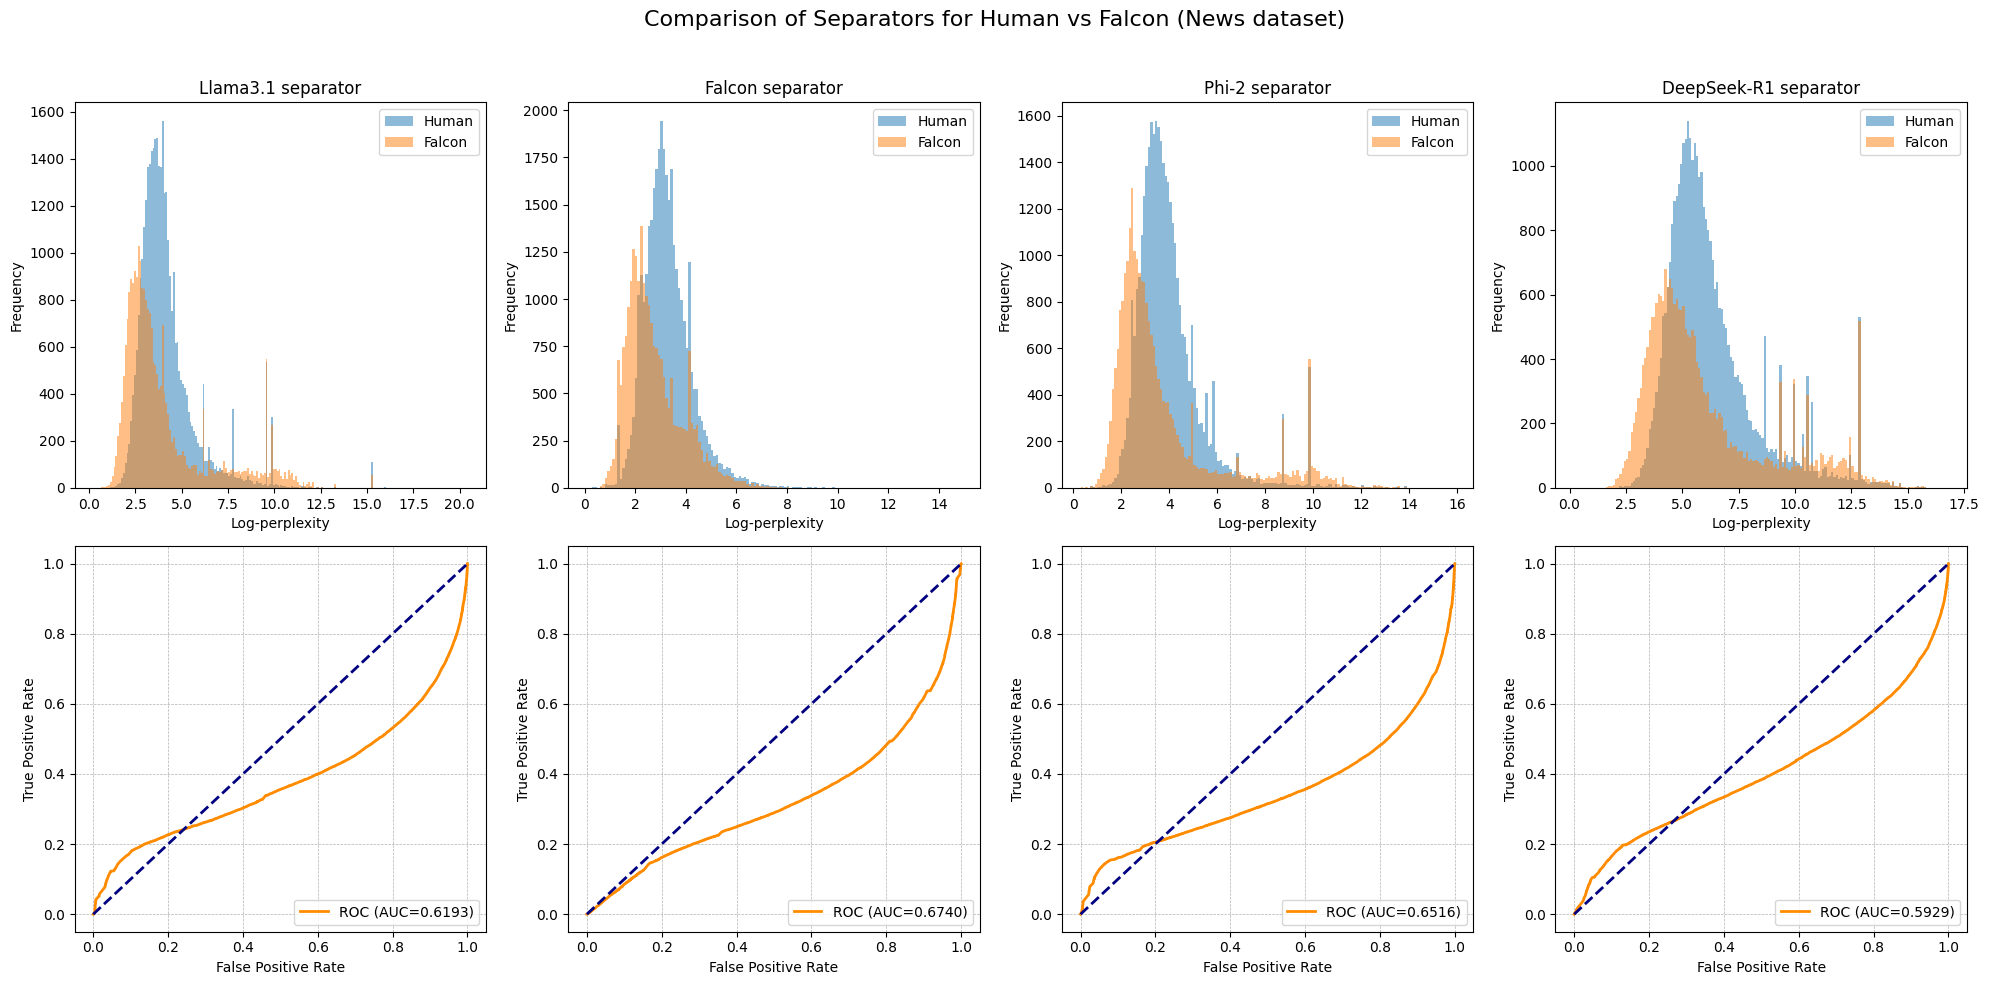

In [69]:
compare_separators(news_paths, "Human", "Falcon")

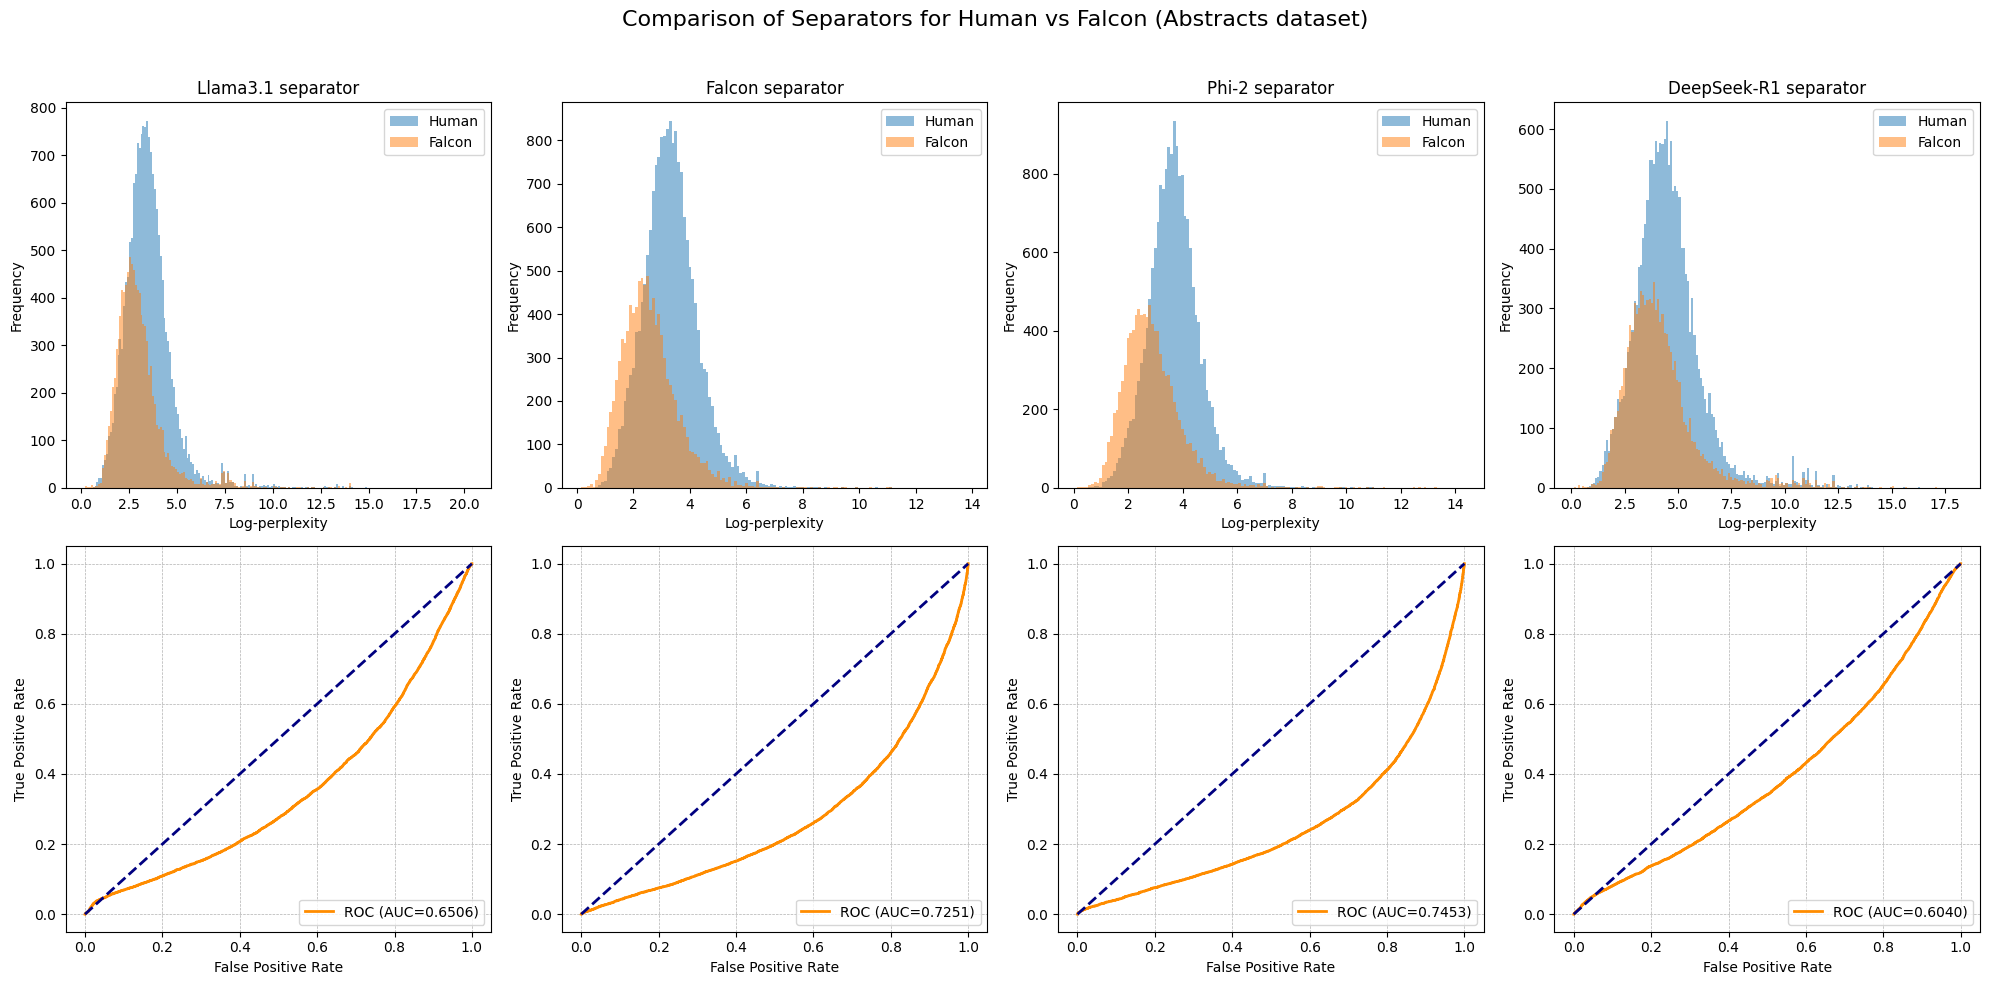

In [63]:
compare_separators(abstracts_paths, "Human", "Falcon")

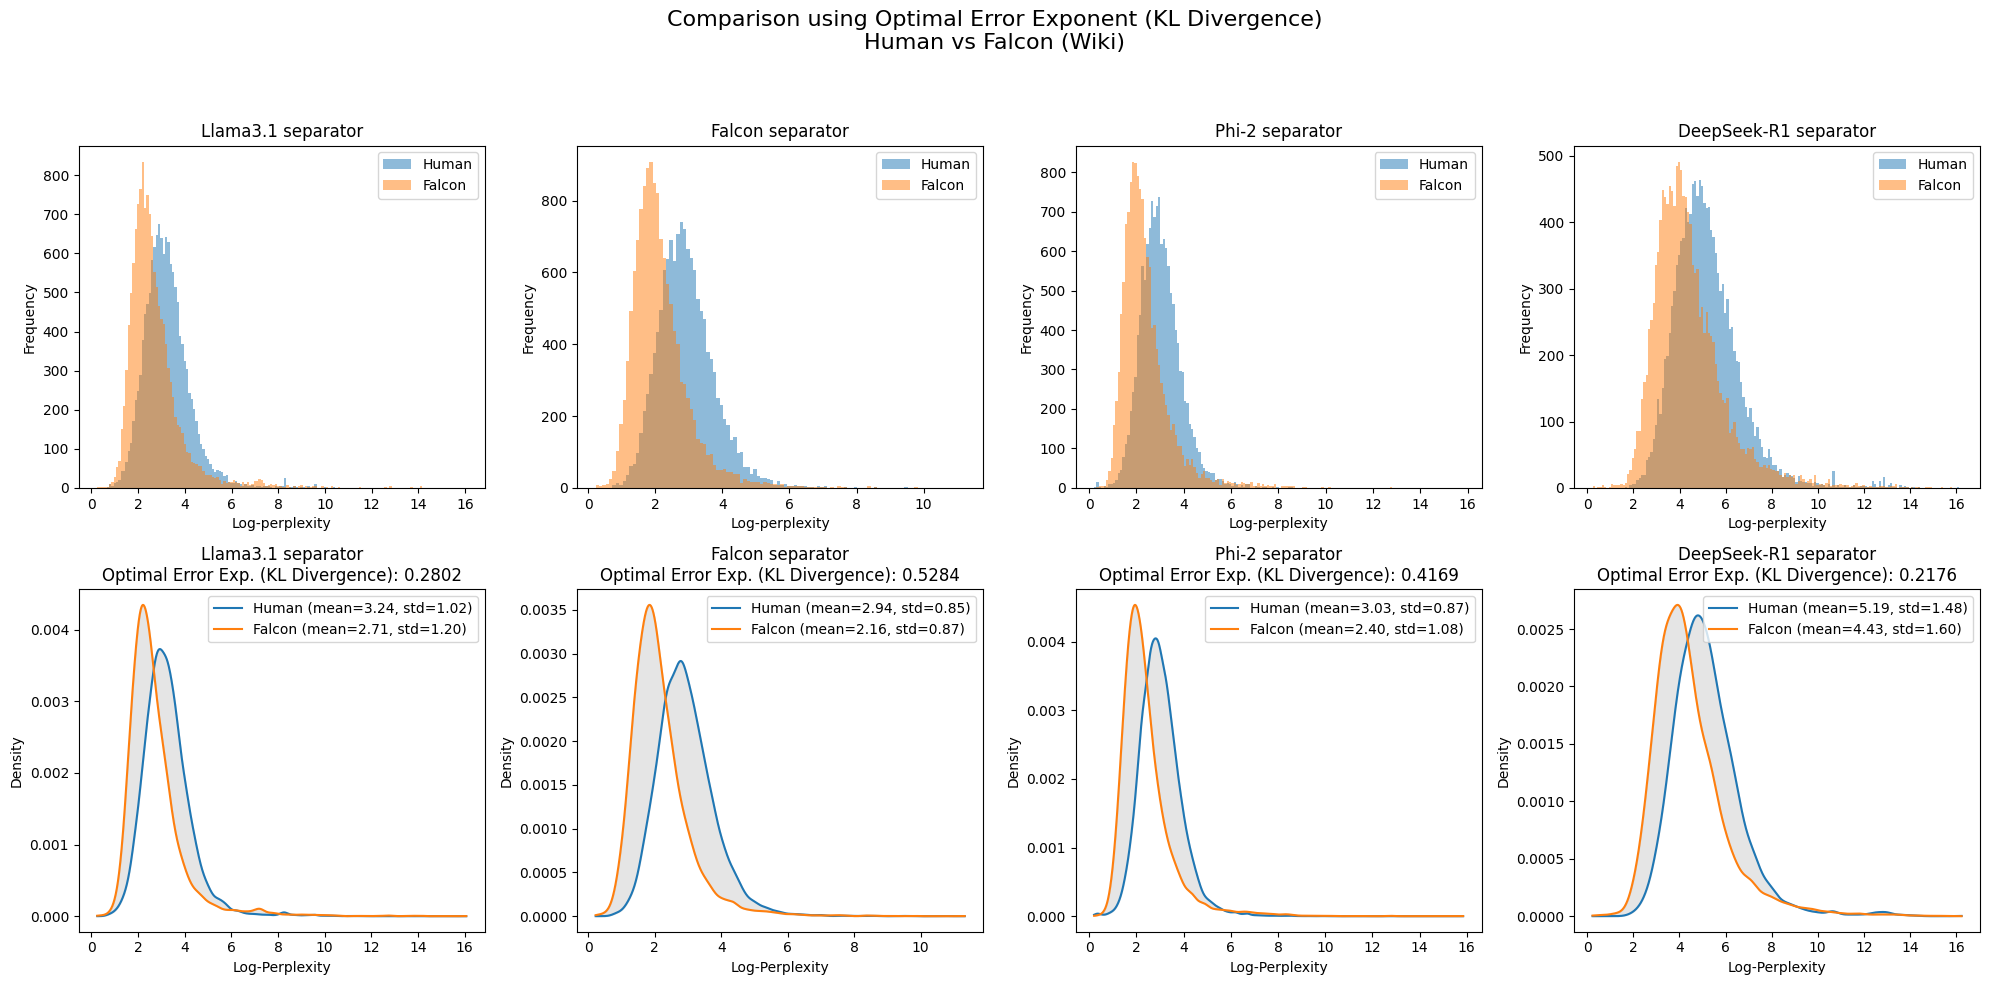

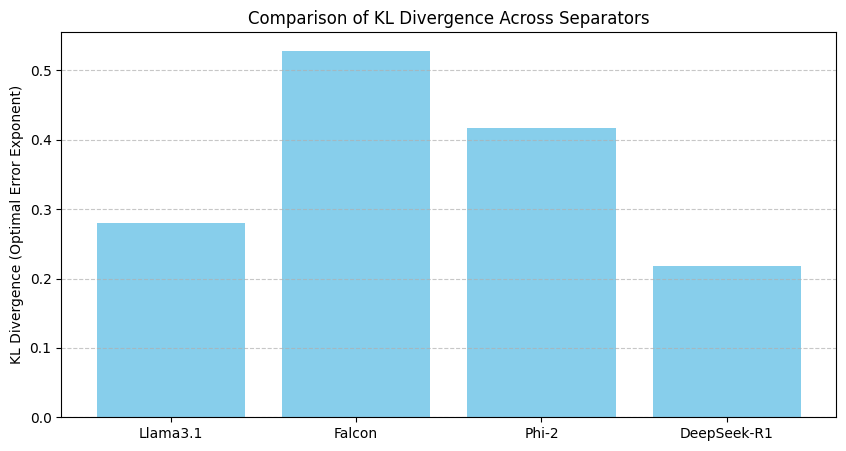

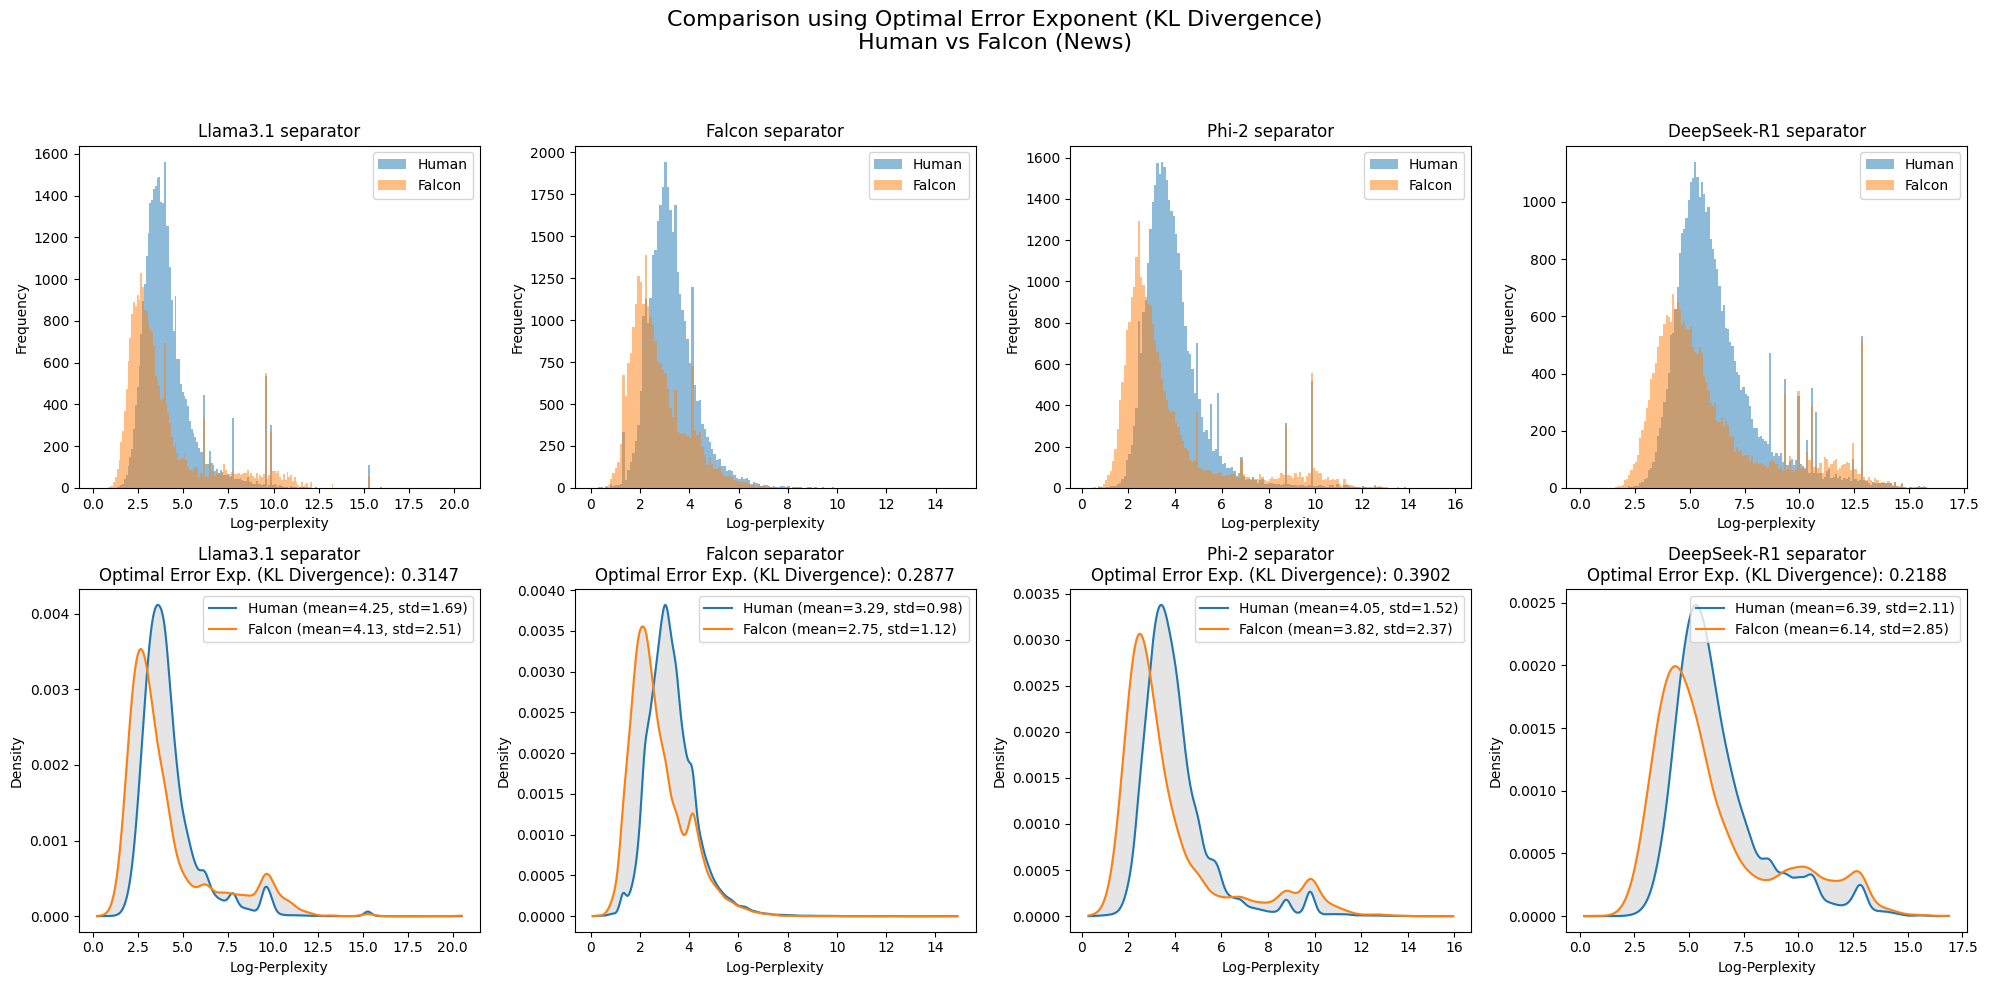

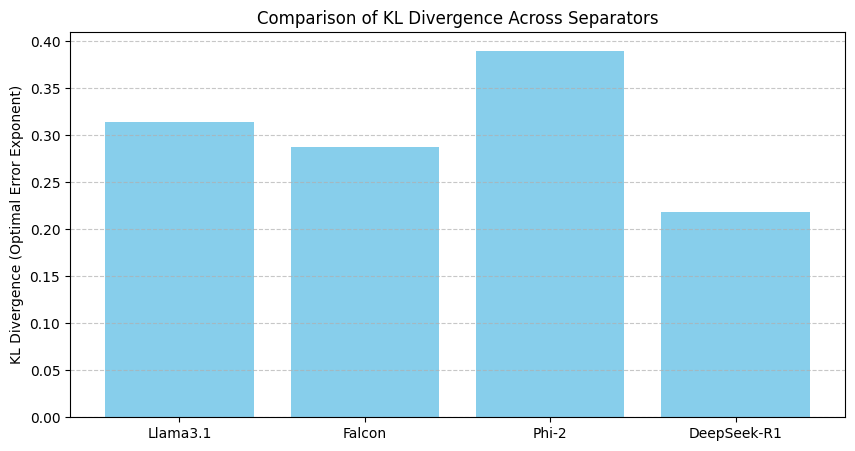

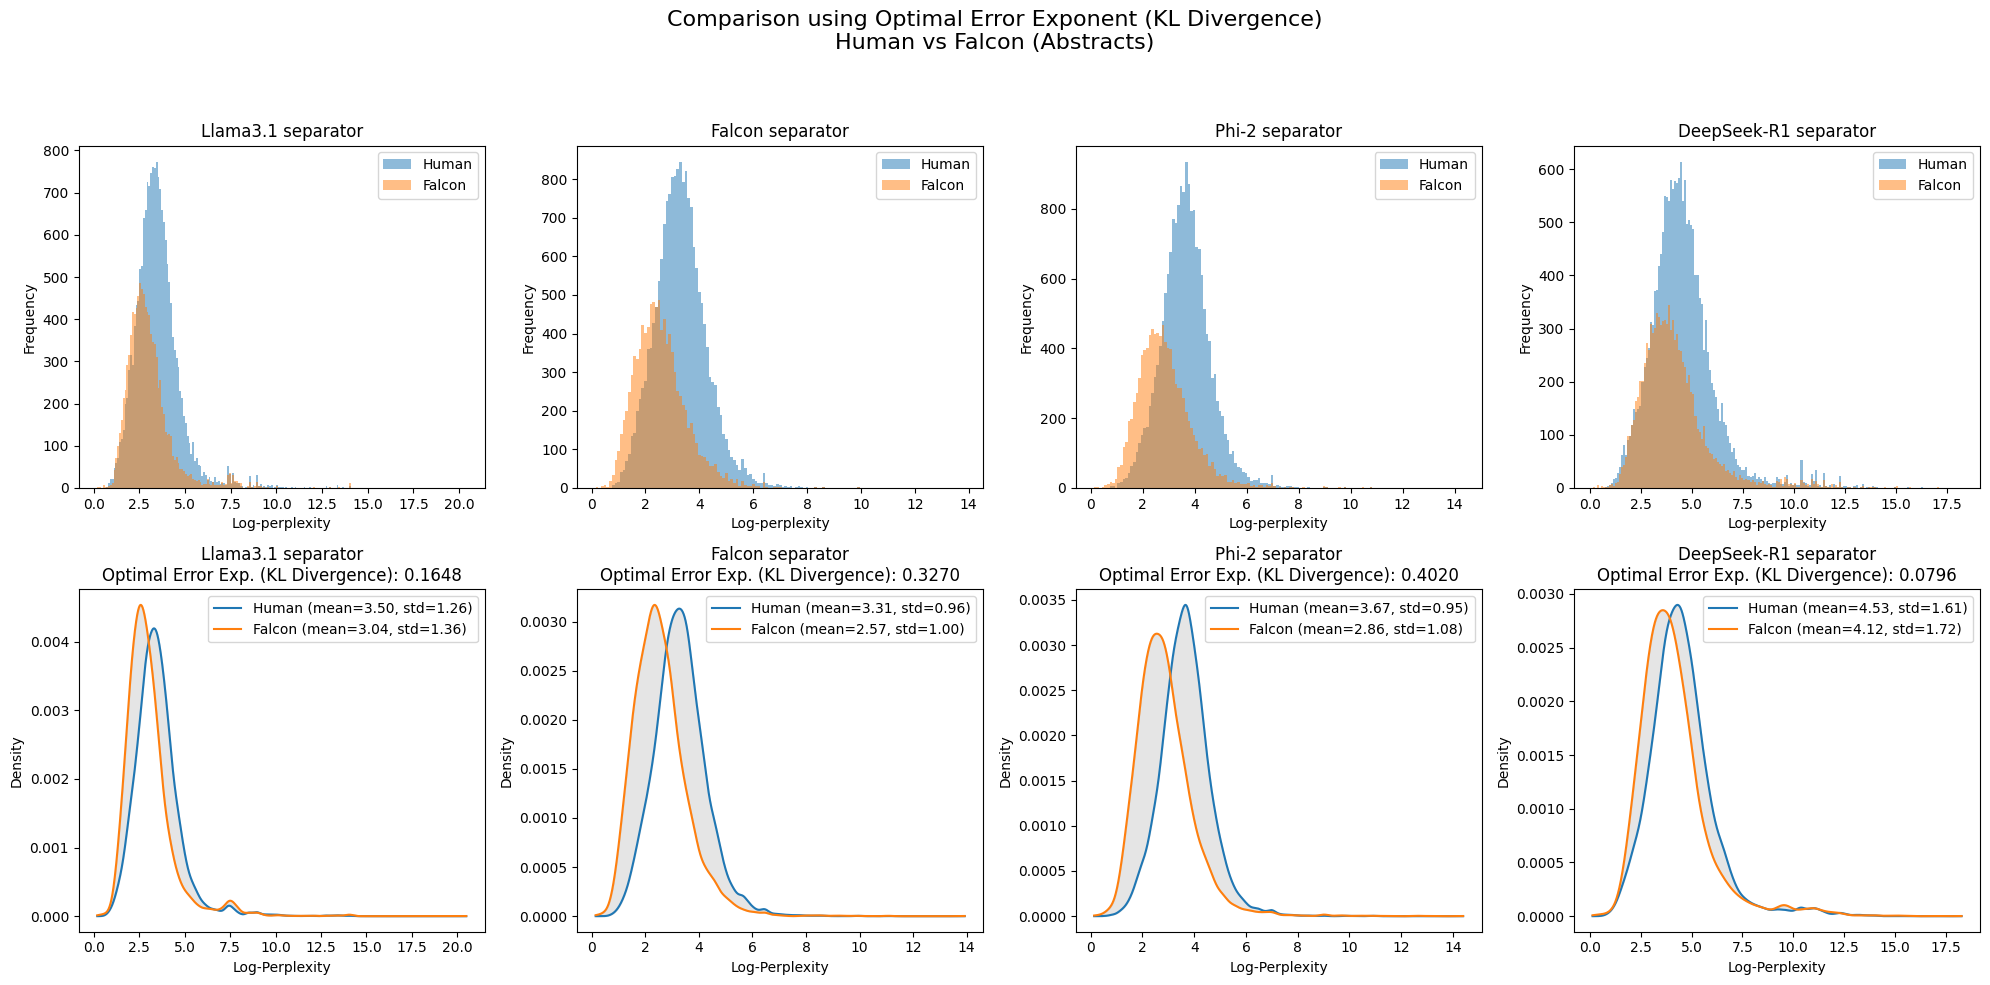

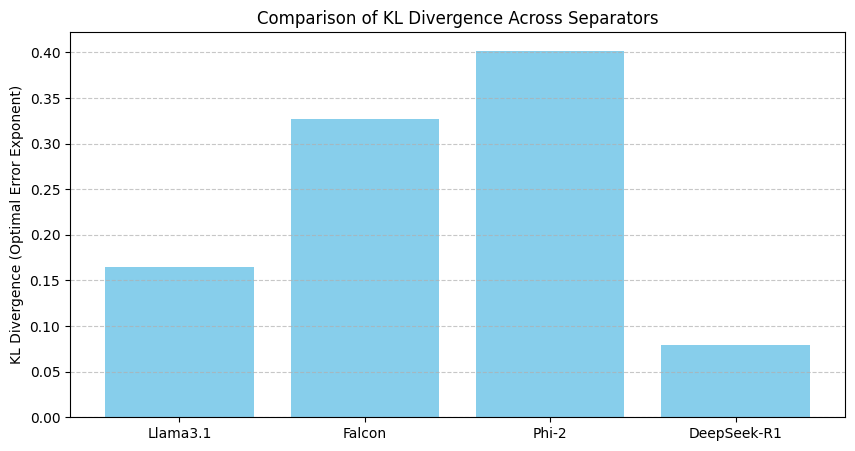

In [88]:
compare_separators_with_kl(wiki_paths, "Human", "Falcon")
compare_separators_with_kl(news_paths, "Human", "Falcon")
compare_separators_with_kl(abstracts_paths, "Human", "Falcon")

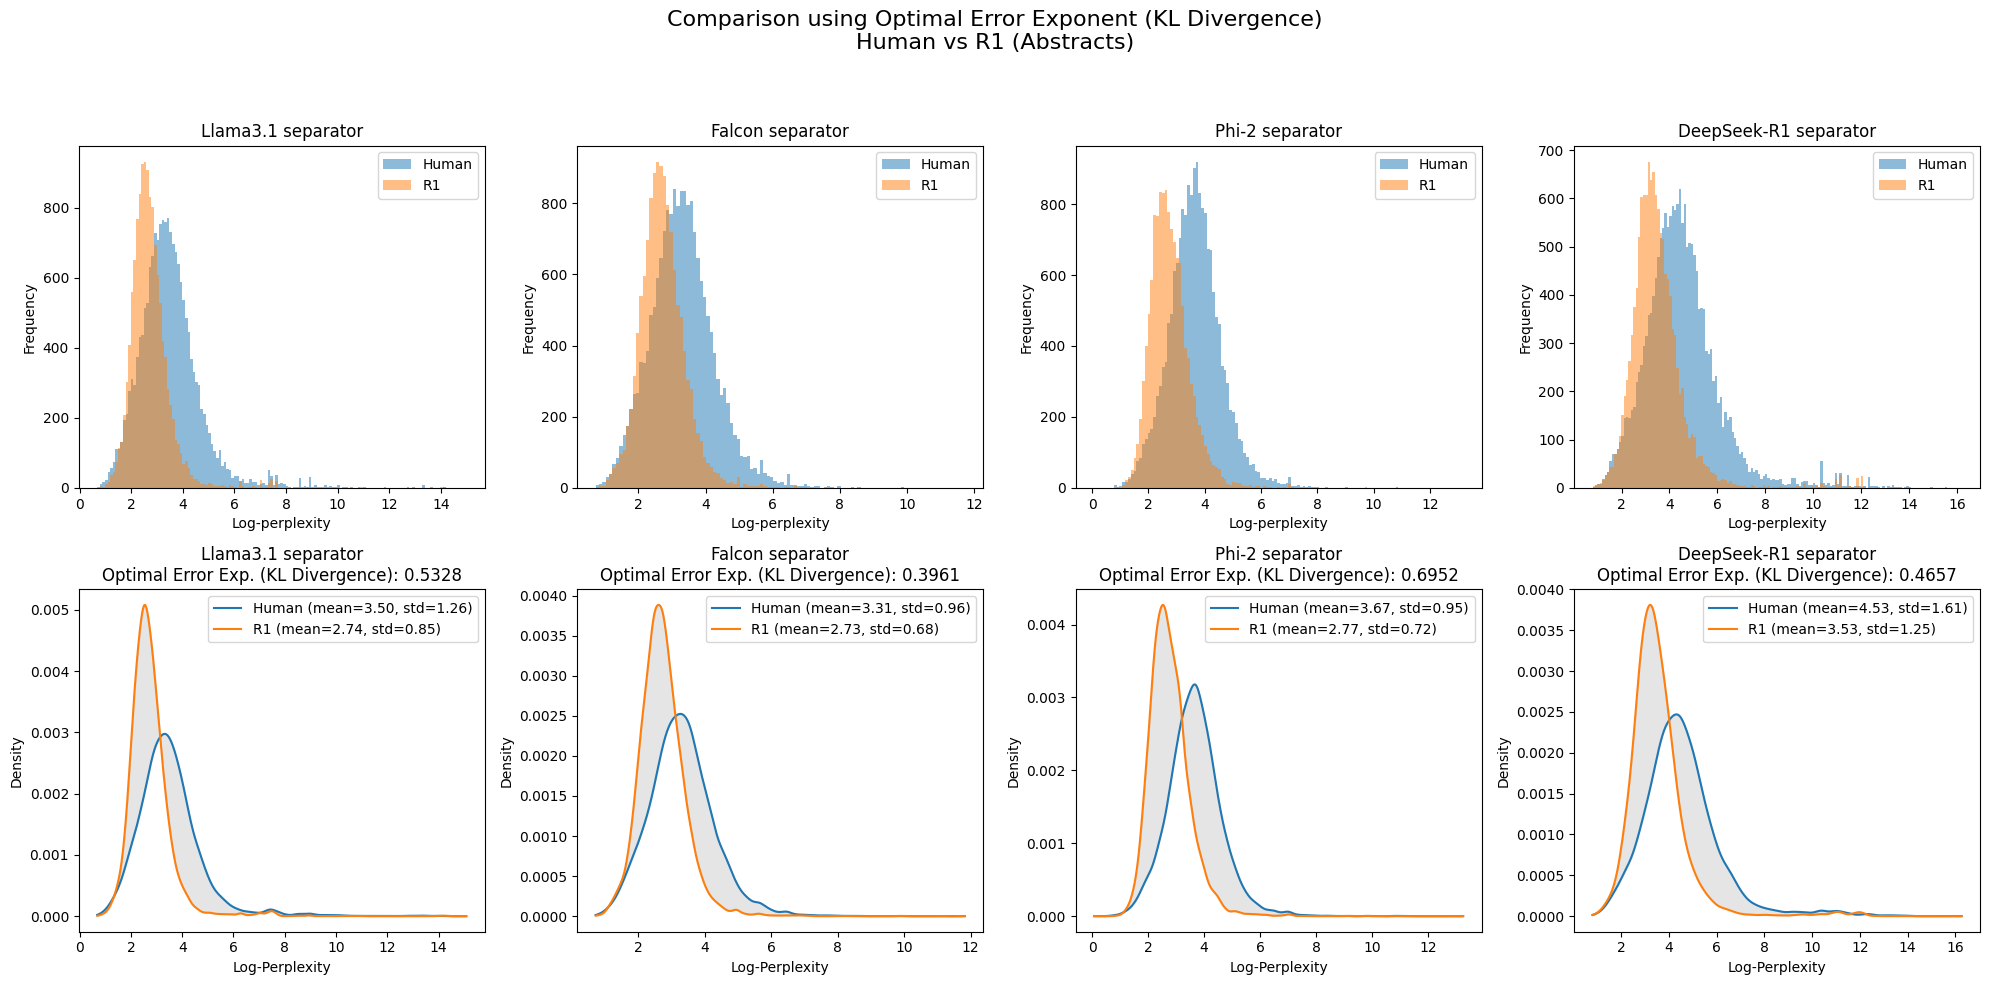

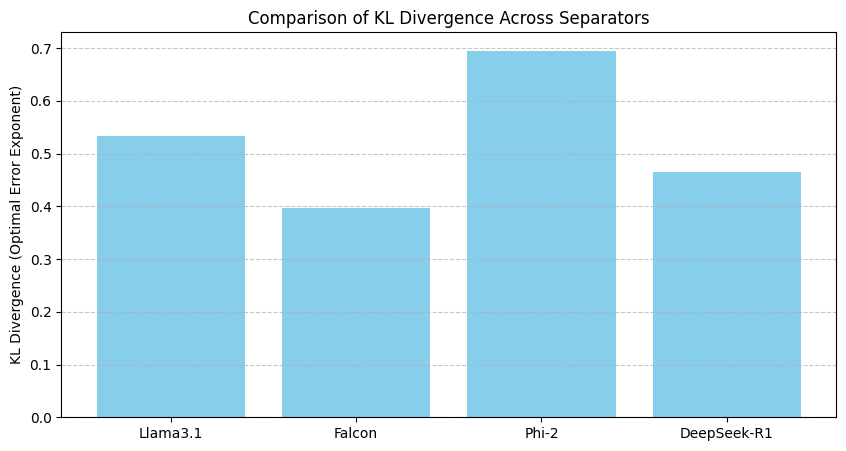

In [98]:
compare_separators_with_kl(abstracts_paths, "Human", "R1")